In [ ]:
!pip3 install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip3 install -q "monai-weekly[nibabel, skimage, pillow, tensorboard, gdown, ignite, torchvision, itk, tqdm, lmdb, psutil,  openslide, pandas, einops, transformers, mlflow, matplotlib, tensorboardX, tifffile, imagecodecs]"
!pip3 install h5py
!python -c "import matplotlib" || pip install -q matplotlib
!pip install -q pytorch-lightning
%matplotlib inline

: 

In [3]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,

)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

import matplotlib.pyplot as plt


from monai.transforms import (
    LoadImage, LoadImaged, EnsureChannelFirstd,
    Resized,  Compose
)
from monai.config import print_config
import re
import torch

ModuleNotFoundError: No module named 'monai'

In [16]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

In [ ]:
set_determinism(seed=0)
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

taken from https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/unetr_btcv_segmentation_3d.ipynb

In [17]:
data_dir = "D:\\dataSets\\CTORG\\"

train_images = sorted(
    glob.glob(os.path.join(data_dir, "volumes 0-49", "*.nii.gz")))

train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labels", "*.nii.gz")))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

image shape: torch.Size([293, 237, 301]), label shape: torch.Size([293, 237, 301])


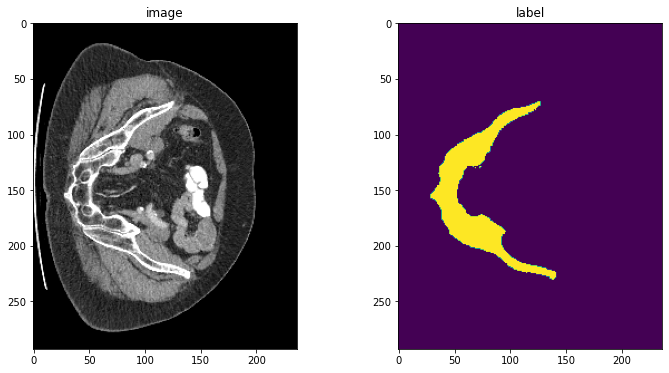

In [18]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

In [19]:
train_ds = Dataset(
    data=train_files, transform=train_transforms)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = Dataset( data=val_files, transform=val_transforms)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

In [20]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

Execute a typical PyTorch training process


In [21]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val

In [22]:

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "best_metric_model.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best



In [23]:


max_iterations = 25000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (X / X Steps) (loss=X.X):   0%|          | 0/131 [00:43<?, ?it/s]


EinopsError: Shape mismatch, can't divide axis of length 267 in chunks of 16